# Homework 5 - Ceteris Paribus (CP), Partial Dependence profiles (PDP) and Accumulated Local Effects (ALE)

## Task 1

Consider a following model:

$f(x_1, x_2) = (x_1 + x_2)^2$

Assume that $x_1, x_2 $ ~ $  U[-1, 1]$ and $x_1=x_2$ (full dependency)

Calculate PD profile for variable $x_1$ in this model.

Extra task: Calculate ME and ALE profiles for variable $x_1$ in this model

### Solution

Partial Dependence:
$$ g_1^{PD}(z) = E_{X_2}[(z + x_2)^2] = E_{X_2}[z^2 + 2z x_2 + x_2 ^ 2] =  $$  $$ = z^2 + 2z * E_{X_2}(x_2) + E_{X_2}(x_2^2) =  $$
$$ = z^2 + 0 + \int_{-1}^{1}{x_2^2} * \frac{1}{2} dx_2 = z^2 + \frac{1}{3}$$

Marginal Effect:
$$ g_1^{ME}(z) = E_{X_2 | X_1=z}[(z + x_2)^2] = E_{X_2 | X_1=z}[(2z)^2] = 4z^2 $$ 

Accumulated Local Effects:
$$ g_1^{AL}(z) = \int_{-1}^{z} \left[E_{X_2 | X_1=v} \frac{\partial[(x_1 + x_2)^2]}{\partial x_1} \right] dv = $$
$$  \int_{-1}^{z} \left[E_{X_2 | X_1=v} (2x_1 + 2x_2) \right] dv = \int_{-1}^{z} 4v  dv = 2(z^2 - 1) $$

## Task 2

The goal of this task is to explain the predictions of models on the wine quality dataset using Ceteris Paribus (CP) and Partial Dependence profiles (PDP), and its variants like Accumulated Local Effects (ALE).


Throughout this notebook, we consistently use the RandomForestClassifier model that we initially trained in Homework 1. Additionally, we exclusively use the LogisticRegression model for the final task.

To depict the sample data, we present two representative data points:
| Feature                | Sample 46 | Sample 98 |
|-------------------------|--------|--------|
| Fixed Acidity           | 6.2    | 9.8    |
| Volatile Acidity        | 0.45   | 0.36   |
| Citric Acid             | 0.26   | 0.46   |
| Residual Sugar          | 4.4    | 10.5   |
| Chlorides               | 0.063  | 0.038  |
| Free Sulfur Dioxide     | 63.0   | 4.0    |
| Total Sulfur Dioxide    | 206.0  | 83.0   |
| Density                 | 0.9940 | 0.9956 |
| pH                      | 3.27   | 2.89   |
| Sulphates               | 0.52   | 0.30   |
| Alcohol                 | 9.8    | 10.1   |


The RandomForest model predicts the probability of being a quality wine at 0.62 and 0.72, resepctively.

#### 3. Two observations can have have different CP profiles.

What is evident is that the CP profiles for the model change based on the specific sample in question, as the model that we use - Random Forest - is capable of capturing the relations between the different variable.

Below we show CP profiles for the above samples 46 and 98. 


<div>
<img src="images/ceteris_paribus.png" width="1000"/>
</div>
</br>



We can see that CP profiles differ between different samples, as we use the Random Forest model. In general, we can observe similar  patterns of monotonicity between CPs of different samples. The trends are not always the same, however, and for the `fixed acidity` the CP for observation 46 decreases as the variable increases, but the CP for observation 98 shows the opposite trend - it actually increases as the acidity incre.

#### 4. Comparison of Ceteris Paribus and Partial Dependence profiles

Below we show the plot showing PDP and CP profiles for the Random forest model. The CP profiles are shown as grey lines and the PDP profiles are shown as a blue-green bold line.

We can observe that CP profiles tend to follow the same trends as PDP, meaning that they tend to increase/decrease/stay at the same variable values. There are visible shifts, that could be explained by general superiority of some instances (best wines are still good even if we change one variable).

<div>
<img src="images/cp_vs_pdp.png" width="1000"/>
</div>
</br>


#### 5. Comparison of PDP between Logistic Regression and Random Forest

In this section, we aim to contrast the PDP between Random Forest with those of Logistic Regression.

<div>
<img src="images/pdp_different_models.png" width="1000"/>
</div>

What is interesting is that for some variables, the linear model captures the same monotonic trend as the Random Forest model (for variables `fixed acidity`, `volatile acidity`, `alcohol`, and to some extent `citric acid`, `residual sugar`, `chlorides`, `pH`, `sulphates`. However, for some variables like `free sulfur dioxide`, `total sulfur dioxide`, the linear model was unable to capture the complex, non-monotnic behaviour that the random forest was capable of.

#### (*) Bonus - custom implementations of CP profiles and PDP

For this homework I additionaly implemented PDP and CP profiles from stratch.
Here are the results of my scripts, for CP profiles with the same observations as before and PDP with 40 sampled data points, both for the variable `alcohol`:

<div>
<img src="images/cp_mine.png" width="700"/>
</div>

<div>
<img src="images/pdp_mine.png" width="700"/>
</div>

The code is provided at the end of the Appendix.

## Appendix

#### 0. Import packages

In [1]:
import dalex as dx

import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (5,3)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

### Train a tree-based ensemble model

#### 0.1 Load dataset

In [2]:
TARGET_COL = 'is_good'

cols = [
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    TARGET_COL
]

df = pd.read_csv('wine_quality.csv', header=0, names=cols)
df[TARGET_COL] = df[TARGET_COL].replace(-1, 0)
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: (4898, 11)
y: (4898,)


#### 0.2 Fit models from Homework 1

In [128]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=25),
    "Forest": RandomForestClassifier(random_state=25)
}

for model in models.values():
    model.fit(X, y)

### 1. Calculate the predictions for some selected observations

In [21]:
indexes = [46, 98]
X_sample = X.iloc[indexes]
print(X_sample.head())

    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
46            6.2              0.45         0.26             4.4      0.063   
98            9.8              0.36         0.46            10.5      0.038   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
46                 63.0                 206.0   0.9940  3.27       0.52   
98                  4.0                  83.0   0.9956  2.89       0.30   

    alcohol  
46      9.8  
98     10.1  


In [22]:
models["Forest"].predict_proba(X_sample)[:,-1]

array([0.62, 0.72])

### 2. Calculate the what-if explanations of these predictions using Ceteris Paribus profiles

In [129]:
explainers = {}

def predict_func(model, df):
    return model.predict_proba(df)[:, 1]


for model_name, model in models.items():
    explainer = dx.Explainer(model, X, y, predict_function=predict_func, label=model_name)
    explainers[model_name] = explainer

Preparation of a new explainer is initiated

  -> data              : 4898 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4898 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : LogisticRegression
  -> predict function  : <function predict_func at 0x1414383a0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.98e-05, mean = 0.0374, max = 0.789
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.6, mean = -6.09e-06, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 4898 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndar

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [154]:
cps = [explainer.predict_profile(new_observation=X_sample) for explainer in explainers.values()]
# cps[1].plot() # uncomment to show the interactive plots

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 87.51it/s]


#### 4. Comparison of a local explanation CP with a global explanation - PDP

In [151]:
pdps = [explainer.model_profile(type="pdp", N=40) for explainer in explainers.values()]
# pdps[1].plot(geom="profiles") # uncomment to show the interactive plots

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 229.14it/s]
/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/dalex/model_explanations/_aggregated_profiles/utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.8    3.904  4.008 ... 13.992 14.096 14.2  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 30.47it/s]
/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/dalex/model_explanations/_aggregated_profiles/utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.8    3.904  4.008 ... 13.992 14.096 14.2  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



#### 5. Comparison of PDP between Logistic Regression and Random Forest

In [153]:
pdps = [explainer.model_profile(type="pdp") for explainer in explainers.values()]
# pdps[0].plot(pdps[1:]) # uncomment to show the interactive plots

Calculating ceteris paribus: 100%|██████████| 11/11 [00:00<00:00, 135.03it/s]
/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/dalex/model_explanations/_aggregated_profiles/utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.8    3.904  4.008 ... 13.992 14.096 14.2  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus: 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]
/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/dalex/model_explanations/_aggregated_profiles/utils.py:144: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 3.8    3.904  4.008 ... 13.992 14.096 14.2  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



### Bonus - my custom implementation of Ceteris Paribus and Partial Dependence profiles

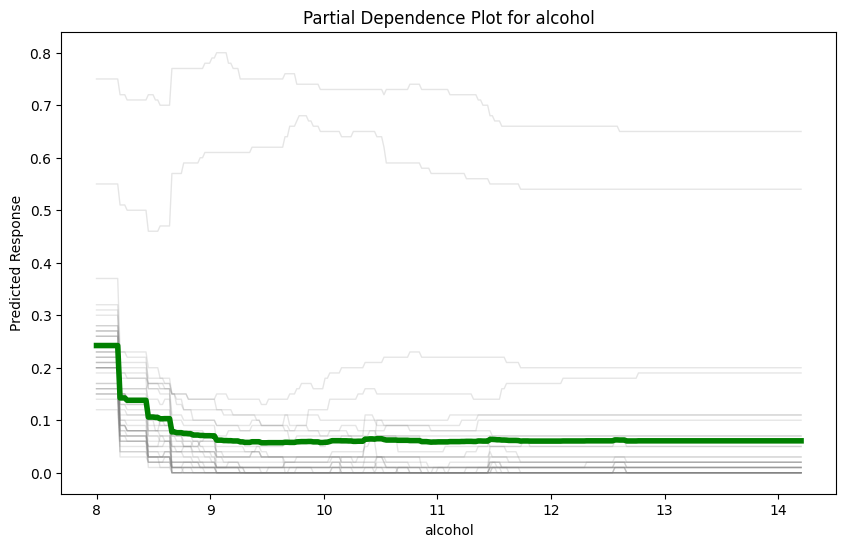

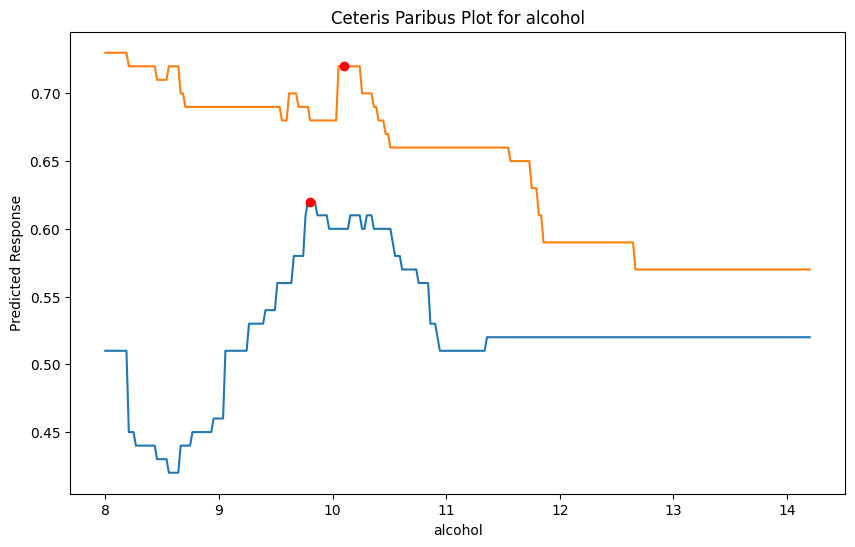

In [144]:
from functools import partial

class Explainer:
    def __init__(self, model, X, y, predict_function=None, resolution=50):
        self.model = model
        self.X = X
        self.y = y
        if predict_function is None:
            self.predict_function = model.predict_proba[:, 1]
        else:
            self.predict_function = partial(predict_function, self.model)
            
        self.resolution = resolution

    def get_cp(self, instance, variable):
        # Creating a range of values for the variable
        variable_range = np.linspace(self.X[variable].min(), self.X[variable].max(), self.resolution)
        predictions = []

        # Generating predictions for each value in the range
        predictions = []
        for val in variable_range:
            temp_instance = instance.copy()
            temp_instance[variable] = val
            predictions.append(self.predict_function(temp_instance))

        predictions = np.array(predictions)

        return variable_range, predictions

    def get_pdp(self, variable, N=30):
        # Randomly selecting N instances from the dataset
        instances = self.X.sample(N)

        variable_range, predictions = self.get_cp(instances, variable)

        # pdp_values = [sum(x)/N for x in predictions]
        pdp_values = predictions

        return variable_range, pdp_values

    def plot_pdp(self, variable, variable_range, values, title=None):
        if title is None:
            title = f'Partial Dependence Plot for {variable}'
        plt.figure(figsize=(10, 6))
        
        plt.plot(variable_range, values, c='grey', alpha=0.2, linewidth=1)
        pdp_values = values.mean(axis=1)
        plt.plot(variable_range, pdp_values, c='green', linewidth=4)
        
        plt.xlabel(variable)
        plt.ylabel('Predicted Response')
        plt.title(title)
        plt.show()

    def plot_cp(self, instance, variable, variable_range, predictions):
        plt.figure(figsize=(10, 6))
        plt.plot(variable_range, predictions)
        original_value = instance[variable]
        plt.scatter([original_value], self.predict_function(instance), color='red', zorder=5, label='Original Instance')
        plt.xlabel(variable)
        plt.ylabel('Predicted Response')
        plt.title(f'Ceteris Paribus Plot for {variable}')
        plt.show()

# Example usage

model = models["Forest"]
explainer = Explainer(model, X, y, predict_function=predict_func, resolution=300)
variable_range, pdps = explainer.get_pdp(variable='alcohol', N=40)
explainer.plot_pdp('alcohol', variable_range, pdps)

variable_range, cps = explainer.get_cp(X.iloc[[46, 98]], variable='alcohol')
explainer.plot_cp(X.iloc[[46, 98]], 'alcohol', variable_range, cps)